<a href="https://colab.research.google.com/github/fatemesima/Vision/blob/main/EfficientNetCubeDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue Sep 16 13:29:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18, resnet34
import os
import torchvision.models as models

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
cp /content/drive/MyDrive/Data/CUB_200_2011.tgz /content/

In [7]:
!tar -xvxf CUB_200_2011.tgz

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.j

In [8]:
import shutil

In [9]:
import os
os.listdir("/content/CUB_200_2011")

['classes.txt',
 'README',
 'images',
 'images.txt',
 'bounding_boxes.txt',
 'train',
 'test',
 'image_class_labels.txt',
 'train_test_split.txt',
 'parts',
 'attributes']

In [10]:
data_dir = '/content/CUB_200_2011/'
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
test_dir = os.path.join(data_dir, 'test')
os.makedirs(test_dir, exist_ok=True)
classes = os.listdir(images_dir)

with open('/content/CUB_200_2011/images.txt') as f:
  image_names = f.readlines()

with open('/content/CUB_200_2011/train_test_split.txt') as f:
  train_test_split = f.readlines()

for train_idx, image_name in zip(train_test_split, image_names):
  num, class_image_name = image_name.split()
  image_idx, train_flag = train_idx.split()
  image_path = os.path.join(images_dir, class_image_name)
  class_name = class_image_name.split('/')[0]
  train_class_dir = os.path.join(train_dir, class_name)
  os.makedirs(train_class_dir, exist_ok=True)
  test_class_dir = os.path.join(test_dir, class_name)
  os.makedirs(test_class_dir, exist_ok=True)
  if train_flag == '0':
    shutil.copy(image_path, train_class_dir)
  else:
    shutil.copy(image_path, test_class_dir)

In [11]:
# Train
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Test
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# trainset = torchvision.datasets.CIFAR100(
#     root='./data', train=True, download=True, transform=transform_train)
trainset = datasets.ImageFolder(root='/content/CUB_200_2011/train/',
                                transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=False, num_workers=2)

# testset = torchvision.datasets.CIFAR100(
#     root='./data', train=False, download=True, transform=transform_test)
testset = datasets.ImageFolder(root='/content/CUB_200_2011/test/',
                                transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=2)

val_dataset   = datasets.ImageFolder("/content/CUB_200_2011/test", transform=val_transform)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [12]:
trainloader

In [13]:
batch = next(iter(trainloader))
batch[0].shape, batch[1].shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

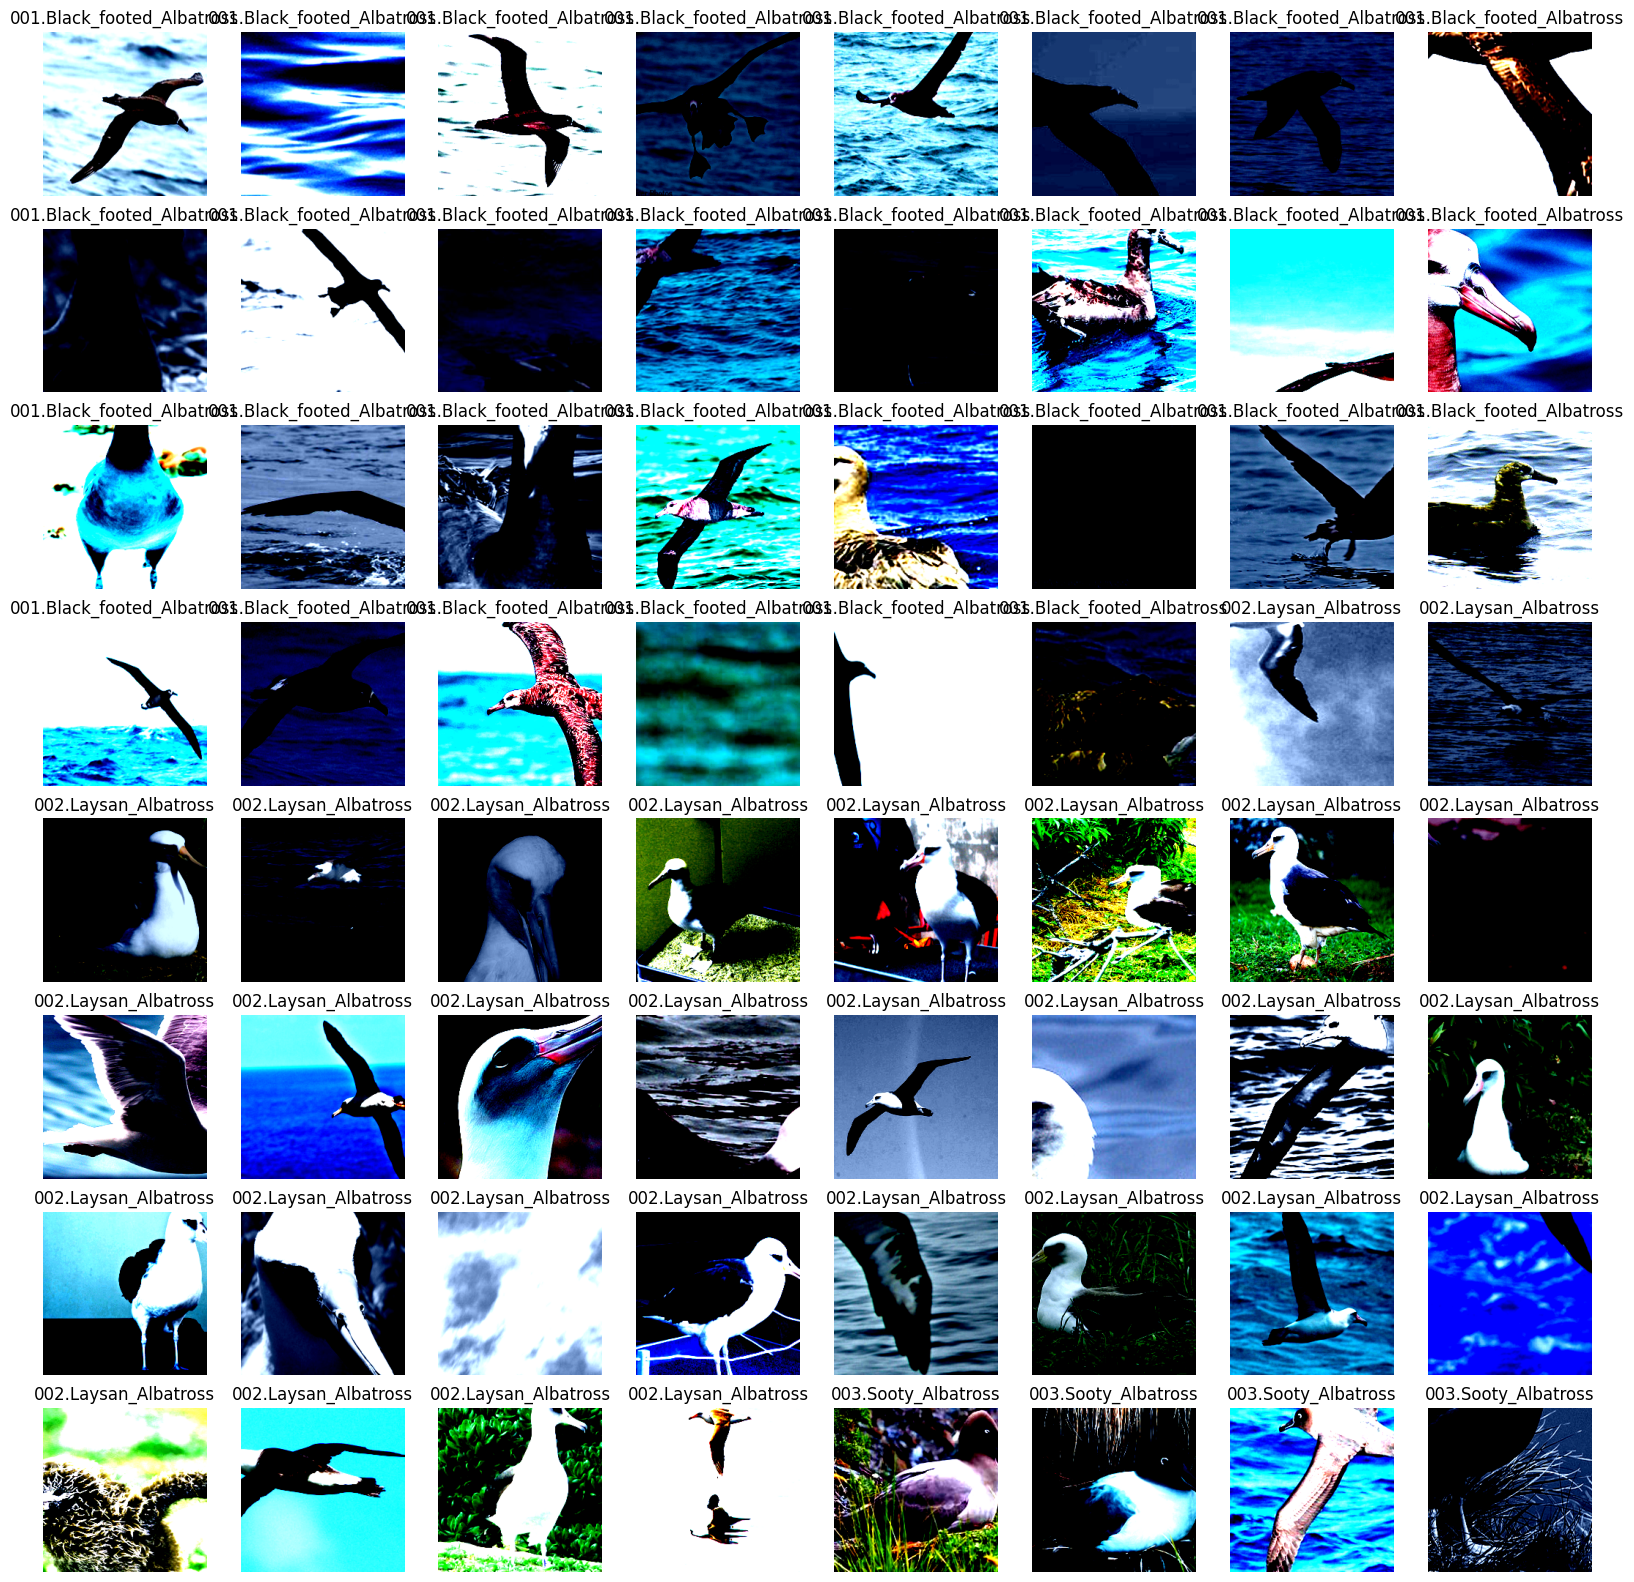

In [15]:
classes = trainset.classes

plot_images(batch[0], batch[1], classes, normalize=False)

In [16]:
from torch.utils.data import Dataset, DataLoader

In [17]:
pip install efficientnet_pytorch

In [18]:
from efficientnet_pytorch import EfficientNet
net = EfficientNet.from_pretrained('efficientnet-b0')
# Dropout
net._fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(1280, 200)
)

Loaded pretrained weights for efficientnet-b0


In [19]:
net.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [20]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.1,
                     # momentum=0.9)

In [21]:
from torch.optim.lr_scheduler import StepLR

In [22]:
from torch.utils.tensorboard import SummaryWriter
import logging


# logger = logging.getLogger('200class')
# logger.setLevel(logging.INFO)


# 🟢 Checkpoint
class Checkpoint(object):
    def __init__(self):
        self.best_acc = 0.
        self.folder = 'checkpoint'
        os.makedirs(self.folder, exist_ok=True)

    def save(self, acc, net, filename, epoch=-1):
        if acc > self.best_acc:
            logger.info(f'Saving checkpoint for epoch {epoch} with acc {acc:.4f}...')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            path = os.path.join(os.path.abspath(self.folder), filename + '.pth')
            torch.save(state, path)
            self.best_acc = acc

    def load(self, net):
        pass


# 🟢 Optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)

# 🟢 Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# 🟢 EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, acc):
        if acc > self.best_acc:
            self.best_acc = acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                logger.info("Early stopping triggered!")
                self.early_stop = True


checkpoint = Checkpoint()
early_stopping = EarlyStopping(patience=10)
writer = SummaryWriter("runs/CUB_200_2011_EfficientNet")



In [23]:
# 🟢 train
def train(epoch):
    net.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(trainloader)
    acc = correct / total

    logger.info(f"Train: Epoch:{epoch} Loss:{avg_loss:.4f} Accuracy:{acc:.4f}")
    writer.add_scalar("Loss/train", avg_loss, epoch)
    writer.add_scalar("Accuracy/train", acc, epoch)


# 🟢test
def test(epoch, checkpoint):
    net.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(testloader)
    acc = correct / total

    logger.info(f"Test:  Epoch:{epoch} Loss:{avg_loss:.4f} Accuracy:{acc:.4f}")
    writer.add_scalar("Loss/test", avg_loss, epoch)
    writer.add_scalar("Accuracy/test", acc, epoch)


    checkpoint.save(acc, net, "best_model", epoch)

    return avg_loss, acc


In [24]:
# 🟢 Loop
# start, end = 0, 30
# for epoch in range(start, end):
#     train(epoch)
#     test_loss, test_acc = test(epoch, checkpoint)
#     scheduler.step(test_loss)  # ⬅️ LR Scheduler
#     # ⬅️ EarlyStopping
#     early_stopping(test_acc)
#     if early_stopping.early_stop:
#         break

# writer.close()

In [25]:
# # 🟢 Loop
# start, end = 0, 30
# for epoch in range(start, end):
#     train(epoch)
#     test_loss, test_acc = test(epoch, checkpoint)
#     scheduler.step(test_loss)  # ⬅️ LR Scheduler
#     # ⬅️ EarlyStopping
#     early_stopping(test_acc)
#     if early_stopping.early_stop:
#         break

# writer.close()

In [26]:
num_classes = 200

In [30]:


# Model: EfficientNet
# -----------------------------
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(in_features, num_classes)
model = model.to(device)

# -----------------------------
# Stage 1: freeze backbone
# -----------------------------
for param in model.features.parameters():
    param.requires_grad = False

optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# Unfreeze function
# -----------------------------
def unfreeze_model(model, new_lr=5e-5):
    for param in model.features.parameters():
        param.requires_grad = True
    return optim.Adam(model.parameters(), lr=new_lr)

# -----------------------------
# Early stopping setup
# -----------------------------
best_acc = 0.0
patience, trigger_times = 5, 0

In [31]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format="INFO:200class:%(message)s")
logger = logging.getLogger("200class")

In [32]:
# Training loop
# -----------------------------
epochs_stage1 = 10   # فقط FC
epochs_stage2 = 30  # کل مدل
total_epochs = epochs_stage1 + epochs_stage2

for epoch in range(total_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / len(trainset)
    epoch_acc = running_corrects.double() / len(trainset)

    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    logger.info(f"Train: Epoch:{epoch} Loss:{epoch_loss:.4f} Accuracy:{epoch_acc:.4f}")
    logger.info(f"Test:  Epoch:{epoch} Loss:{val_loss:.4f} Accuracy:{val_acc:.4f}")

    # Save best checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f"checkpoint_epoch{epoch}.pth")
        logger.info(f"Saving checkpoint for epoch {epoch} with acc {val_acc:.4f}...")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
          logger.info("Early stopping triggered!")
          break

    # Unfreeze backbone after stage 1
    if epoch == epochs_stage1 - 1:
        logger.info("🔓 Unfreezing EfficientNet backbone...")
        optimizer = unfreeze_model(model, new_lr=1e-4)

INFO:200class:Train: Epoch:0 Loss:7.0897 Accuracy:0.0003
INFO:200class:Test:  Epoch:0 Loss:5.2201 Accuracy:0.0657
INFO:200class:Saving checkpoint for epoch 0 with acc 0.0657...
INFO:200class:Train: Epoch:1 Loss:5.4687 Accuracy:0.0240
INFO:200class:Test:  Epoch:1 Loss:4.7764 Accuracy:0.1128
INFO:200class:Saving checkpoint for epoch 1 with acc 0.1128...
INFO:200class:Train: Epoch:2 Loss:5.2988 Accuracy:0.0297
INFO:200class:Test:  Epoch:2 Loss:4.5534 Accuracy:0.1331
INFO:200class:Saving checkpoint for epoch 2 with acc 0.1331...
INFO:200class:Train: Epoch:3 Loss:5.1126 Accuracy:0.0485
INFO:200class:Test:  Epoch:3 Loss:4.3873 Accuracy:0.1496
INFO:200class:Saving checkpoint for epoch 3 with acc 0.1496...
INFO:200class:Train: Epoch:4 Loss:4.9634 Accuracy:0.0649
INFO:200class:Test:  Epoch:4 Loss:4.2478 Accuracy:0.1653
INFO:200class:Saving checkpoint for epoch 4 with acc 0.1653...
INFO:200class:Train: Epoch:5 Loss:4.8074 Accuracy:0.0808
INFO:200class:Test:  Epoch:5 Loss:4.1372 Accuracy:0.1758
I